## Stochastic methods
### Getting started
All exercises rely on chainladder v0.5.5 and later.  There have also been breaking changes with `pandas 1.0` and if you are using an earlier version, date slicing may behave differently.

In [1]:
import pandas as pd
import numpy as np
import chainladder as cl
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
print('chainladder:' + cl.__version__)
print('pandas:' + pd.__version__)

chainladder:0.7.9
pandas:1.0.4


### MackChainladder Intro

Like the basic `Chainladder` method, the `MackChainladder` is entirely specified by its development pattern selections.  In fact, it is the basic `Chainladder` with a few extra features.  Let's explore this a bit more with the Workers' Compensation industry triangle.

In [2]:
tri = cl.load_sample('clrd').groupby('LOB').sum().loc['wkcomp', ['CumPaidLoss', 'EarnedPremNet']]
cl.Chainladder().fit(tri['CumPaidLoss']).ultimate_ == \
cl.MackChainladder().fit(tri['CumPaidLoss']).ultimate_

True

Let's create a Mack Model.

In [40]:
mack = cl.MackChainladder().fit(tri['CumPaidLoss'])

MackChainladder has the following additional fitted features that the deterministic `Chainladder` does not.

1. `full_std_err_`:  The full standard error
2. `total_process_risk_`: The total process error
3. `total_parameter_risk_`: The total parameter error
4. `mack_std_err_`: The total prediction error by origin period
5. `total_mack_std_err_`: The total prediction error across all origin periods

Notice these are all measures of uncertainty, but where do they come from?  Let's start by examining the `link_ratios` underlying the triangle.

In [44]:
tri_first_lags = tri[tri.development<=24][tri.origin<'1997']['CumPaidLoss']
tri_first_lags

,12,24
1988,"285,804","638,532"
1989,"307,720","684,140"
1990,"320,124","757,479"
1991,"347,417","793,749"
1992,"342,982","781,402"
1993,"342,385","743,433"
1994,"351,060","750,392"
1995,"343,841","768,575"
1996,"381,484","736,040"


A simple average link-ratio can be directly computed as follows:

In [45]:
tri_first_lags.link_ratio.to_frame().mean().values[0]

2.2066789527531494

Verifying that this ties to our `Development` object:

In [46]:
cl.Development(average='simple').fit(tri['CumPaidLoss']).ldf_.to_frame().values[0, 0]

2.2066789527531494

### A linear regression framework

Mack noticed that this estimate for an LDF is really just a linear regression fit.  For the case of the `simple` average, it is a weighted regression where the weight is set to $\left (\frac{1}{X}  \right )^{2}$.

Take a look at the fitted coefficient in the next cell and verify that it ties to the direct calculations above.
With the regression framework in hand, we get much more information about our LDF estimate than just the coefficient.

In [47]:
import statsmodels.api as sm
import numpy as np
y = tri_first_lags.to_frame().values[:, 1]
X = tri_first_lags.to_frame().values[:, 0]

model = sm.WLS(y, X, weights=(1/X)**2)
results = model.fit()
results.summary()

/Users/holmen1/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.997
Model:                            WLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              2887.
Date:                Tue, 29 Dec 2020   Prob (F-statistic):                    1.60e-11
Time:                        16:55:23   Log-Likelihood:                         -107.89
No. Observations:                   9   AIC:                                      217.8
Df Residuals:                       8   BIC:                                      218.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2067      0.041     53.735      0.000       2.112       2.301
==============================================================================
Omnibus:                        7.448   Durbin-Watson:                   1.177
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                2.533
Skew:                          -1.187   Prob(JB):                        0.282
Kurtosis:                       4.058   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

By toggling the weights of our regression, we can handle the most common types of averaging used in picking loss development factors.

In [48]:
print('Does this work for simple?')
print(round(cl.Development(average='simple').fit(tri_first_lags).ldf_.to_frame().values[0, 0], 8) == \
      round(sm.WLS(y, X, weights=(1/X)**2).fit().params[0],8))
print('Does this work for volume-weighted average?')
print(round(cl.Development(average='volume').fit(tri_first_lags).ldf_.to_frame().values[0, 0], 8) == \
      round(sm.WLS(y, X, weights=(1/X)).fit().params[0],8))
print('Does this work for regression average?')
print(round(cl.Development(average='regression').fit(tri_first_lags).ldf_.to_frame().values[0, 0], 8) == \
      round(sm.OLS(y, X).fit().params[0],8))

Does this work for simple?
True
Does this work for volume-weighted average?
True
Does this work for regression average?
True


This regression framework is what the `Development` estimator uses to set development patterns.  Although we discard the information in deterministic approaches, `Development` has two useful statistics for estimating reserve variability, both of which come from the regression framework.  The stastics are `std_err_` and `sigma_` and they are used by the `MackChainladder` estimator to determine the prediction error of our reserves.

In [49]:
dev = cl.Development(average='simple').fit(tri['CumPaidLoss'])

In [50]:
dev.std_err_

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
(All),0.0411,0.0120,0.0051,0.0037,0.0033,0.0033,0.0042,0.0068,0.0032


In [51]:
dev.sigma_

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
(All),0.1232,0.0340,0.0135,0.0091,0.0074,0.0067,0.0073,0.0097,0.0032


Since the regression framework is weighted, we can easily turn on/off any observation we want using the dropping capabilities of the `Development` estimator.  Dropping link ratios not only affects the `ldf_` and `cdf_`, but also the `std_err_` and `sigma` of the regression.

Here we eliminate the 1988 valuation from our triangle, which is identical to eliminating the first observation from our 12-24 regression fit.

In [52]:
print('Does this work for dropping observations?')
print(round(cl.Development(average='volume', drop_valuation='1988') \
              .fit(tri['CumPaidLoss']).std_err_.to_frame().values[0, 0], 8) == \
      round(sm.WLS(y[1:], X[1:], weights=(1/X[1:])).fit().bse[0],8))

Does this work for dropping observations?
True


With `sigma_` and `std_err_` in hand, Mack goes on to develop recursive formulas to estimate `parameter_risk_` and `process_risk_`.

In [53]:
mack.parameter_risk_

,12,24,36,48,60,72,84,96,108,120,9999
1988,0,0,0,0,0,0,0,0,0,0,0
1989,0,0,0,0,0,0,0,0,0,"5,251","5,251"
1990,0,0,0,0,0,0,0,0,"9,520","11,183","11,183"
1991,0,0,0,0,0,0,0,"5,984","11,629","13,161","13,161"
1992,0,0,0,0,0,0,"4,588","7,468","12,252","13,648","13,648"
1993,0,0,0,0,0,"4,037","5,981","8,187","12,259","13,502","13,502"
1994,0,0,0,0,"4,163","5,980","7,555","9,503","13,302","14,506","14,506"
1995,0,0,0,"4,921","6,736","8,137","9,446","11,118","14,502","15,620","15,620"
1996,0,0,"8,824","11,289","12,895","14,101","15,190","16,513","19,141","20,090","20,090"
1997,0,"14,499","21,075","24,749","27,093","28,657","29,907","31,164","33,103","33,897","33,897"


### Assumption of Independence
The Mack model makes a lot of assumptions about independence (i.e. covariance between random processes is 0).  This means many of the Variance estimates in the `MackChainladder` model follow the form of $Var(A+B) = Var(A)+Var(B)$.

Notice the square of `mack_std_err_` is simply the sum of the sqaures of `parameter_risk_` and `process_risk_`.

In [54]:
print('Parameter risk and process risk are independent?')
print(round(mack.mack_std_err_**2, 4) == round(mack.parameter_risk_**2 + mack.process_risk_**2, 4))

Parameter risk and process risk are independent?
True


This independence assumption applies to variance of each origin period.

In [55]:
print('Total Parameter and process risk across origin periods is independent?')
print(round(mack.total_process_risk_**2, 4) == round((mack.process_risk_**2).sum('origin'), 4))

Total Parameter and process risk across origin periods is independent?
True


Independence is also assumed to apply to the overall standard error of reserves, `total_mack_std_err_`.

In [56]:
(mack.total_process_risk_**2 + mack.total_parameter_risk_**2).to_frame().values[0, -1] == \
(mack.total_mack_std_err_**2).values[0,0]

False

This over-reliance on independence is one of the weaknesses of the `MackChainladder` method. Nevertheless, if the data align with this assumption, then `total_mack_std_err_` is a reasonable esimator of reserve variability.

### Mack Reserve Variability
The `mack_std_err_` at ultimate is the reserve variability for each `origin` period.

In [57]:
mack.mack_std_err_[mack.mack_std_err_.development==mack.mack_std_err_.development.max()]

,9999
1988,
1989,"7,313"
1990,"17,838"
1991,"21,814"
1992,"23,847"
1993,"25,283"
1994,"28,465"
1995,"33,172"
1996,"50,244"
1997,"99,027"


These are probably easier to see in the `summary_` of the `MackChainladder` model.

In [58]:
mack.summary_

,Latest,IBNR,Ultimate,Mack Std Err
1988,"1,241,715",,"1,241,715",
1989,"1,308,706","13,321","1,322,027","7,313"
1990,"1,394,675","42,210","1,436,885","17,838"
1991,"1,414,747","79,409","1,494,156","21,814"
1992,"1,328,801","119,709","1,448,510","23,847"
1993,"1,187,581","167,192","1,354,773","25,283"
1994,"1,114,842","260,401","1,375,243","28,465"
1995,"962,081","402,403","1,364,484","33,172"
1996,"736,040","636,834","1,372,874","50,244"
1997,"340,132","1,056,335","1,396,467","99,027"


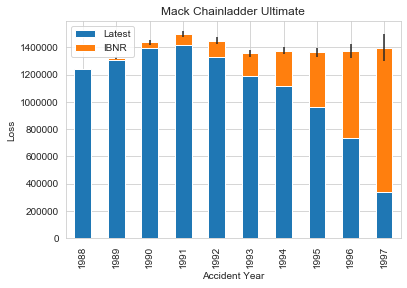

In [60]:
plot_data = mack.summary_.to_frame()
g = plot_data[['Latest', 'IBNR']] \
    .plot(kind='bar', stacked=True,
          yerr=pd.DataFrame({'latest': plot_data['Mack Std Err']*0,
                             'IBNR': plot_data['Mack Std Err']}),
          ylim=(0, None), title='Mack Chainladder Ultimate')
g.set_xlabel('Accident Year')
g.set_ylabel('Loss');

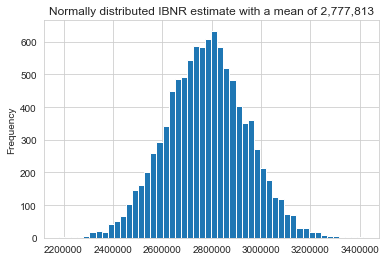

In [61]:
dist = pd.Series(np.random.normal(mack.ibnr_.sum(),
                           mack.total_mack_std_err_.values[0, 0], size=10000))
dist.plot(
    kind='hist', bins=50,
    title="Normally distributed IBNR estimate with a mean of " + '{:,}'.format(round(mack.ibnr_.sum(),0))[:-2]);

### ODP Bootstrap Model

The `MackChainladder` focused on a regression framework for determining the variability of reserve estimates.  An alternative approach is to use statistical bootstrapping or sampling from a triangle with replacement to simulate new triangles.

Bootstrapping imposes less model constraints than the `MackChainladder` which allows for greater applicability in different scenarios.  Sampling new triangles can be accomplished through the `BootstrapODPSample` estimator.  This estimator will take a single triangle and simulate new ones from it.

Notice how easy it is to simulate 10,000 new triangles from an existing triangle by accessing the `resampled_triangles_` attribute.

In [62]:
samples = cl.BootstrapODPSample(n_sims=10000).fit(tri['CumPaidLoss']).resampled_triangles_

Alternatively, we could use `BootstrapODPSample` to transform our triangle into a resampled set.

In [63]:
samples = cl.BootstrapODPSample(n_sims=10000).fit_transform(tri['CumPaidLoss'])

The notion of the ODP Bootstrap is that as our simulations approach infinity, we should expect our mean simulation to converge on the basic `Chainladder` estimate of of reserves.

Let's apply the basic chainladder to our original triangle and also to our simulated triangles to see whether this holds true.

In [64]:
difference = round(1 - cl.Chainladder().fit(samples).ibnr_.sum('origin').mean() / \
                       cl.Chainladder().fit(tri['CumPaidLoss']).ibnr_.sum())
print("Percentage difference in estimate using original triangle and BootstrapODPSample is " +str(difference))

Percentage difference in estimate using original triangle and BootstrapODPSample is -0.0


### Using deterministic methods with Bootstrap samples
Our `samples` is just another triangle object with all the functionality of a regular triangle.  This means we can apply any functionality we want to our `samples` including any deterministic methods we learned about previously.

In [65]:
samples

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(10000, 1, 10, 10)"
Index:,[LOB]
Columns:,[CumPaidLoss]


In [66]:
pipe = cl.Pipeline([
    ('dev', cl.Development(average='simple')),
    ('tail', cl.TailConstant(1.05))])
pipe.fit(samples)

Pipeline(memory=None,
         steps=[('dev',
                 Development(average='simple', drop=None, drop_high=None,
                             drop_low=None, drop_valuation=None, fillna=None,
                             n_periods=-1, sigma_interpolation='log-linear')),
                ('tail',
                 TailConstant(attachment_age=None, decay=0.5, tail=1.05))],
         verbose=False)

Now instead of a single `cdf_` vector, we have 10,000.

In [67]:
pipe.named_steps.dev.cdf_

,Triangle Summary
Valuation:,2262-03
Grain:,OYDY
Shape:,"(10000, 1, 1, 9)"
Index:,[LOB]
Columns:,[CumPaidLoss]


This allows us to look at the varibility of any fitted property used in our prior tutorials.

12-24 LDF of original Triangle: 2.2067


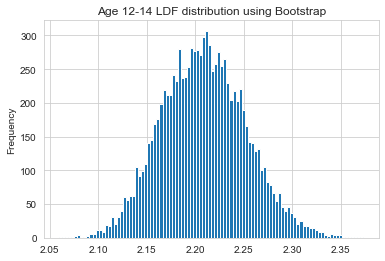

In [68]:
orig_dev = cl.Development(average='simple').fit(tri['CumPaidLoss'])
resampled_ldf = pipe.named_steps.dev.ldf_
print("12-24 LDF of original Triangle: " + str(round(orig_dev.ldf_.values[0,0,0,0],4)))
pd.Series(resampled_ldf.values[:, 0, 0, 0]).plot(
    kind='hist', bins=100,
    title='Age 12-14 LDF distribution using Bootstrap');

### Comparison between Bootstrap and Mack
We should even be able to approximate some of the Mack parameters calculated using the regression framework.

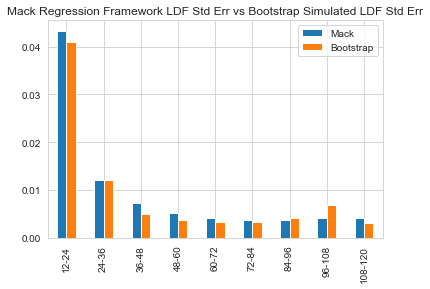

In [69]:
mack_vs_bs = resampled_ldf.std('index').to_frame().append(
    orig_dev.std_err_.to_frame()).T
mack_vs_bs.columns = ['Mack', 'Bootstrap']
mack_vs_bs.plot(kind='bar', title='Mack Regression Framework LDF Std Err vs Bootstrap Simulated LDF Std Err');

While the `MackChainladder` produces statistics about the mean and variance of reserve estimates, those have to be fit to a distribution using MLE, MoM, etc to see the range of outcomes of reserves.  With `BootstrapODPSample` based fits, we can use the empirical distribution directly if we choose to.

In [70]:
ibnr = cl.Chainladder().fit(samples).ibnr_.sum('origin')
ibnr_99 = ibnr.quantile(q=0.99)
print("99%-ile of reserve estimate is " +'{:0,}'.format(round(ibnr_99,0)))

99%-ile of reserve estimate is 3,142,169.0


Let's see how the `MackChainladder` reserve distribution compares to the `BootstrapODPSample` reserve distribution.

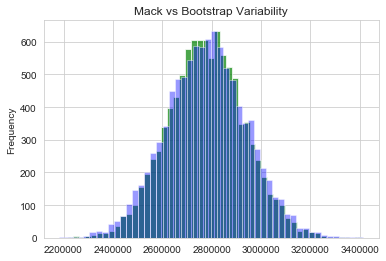

In [71]:
ax = ibnr.plot(kind='hist', bins=50, alpha=0.7, color='green').plot()
dist.plot(kind='hist', bins=50, alpha=0.4, color='blue', title='Mack vs Bootstrap Variability');

### Expected loss methods with Bootstrap

So far, we've only applied the multiplicative methods (i.e. basic chainladder) in a stochastic context.  It is possible to use an expected loss method like the `BornhuetterFerguson`. 

To do this, we will need an exposure vector.

In [72]:
tri['EarnedPremNet'].latest_diagonal

,1997
1988,"1,691,130"
1989,"1,797,930"
1990,"1,880,315"
1991,"2,064,835"
1992,"2,189,448"
1993,"2,482,657"
1994,"2,594,787"
1995,"2,616,831"
1996,"2,420,655"
1997,"2,207,902"


Passing an `apriori_sigma` to the `BornhuetterFerguson` estimator tells it to consider the apriori selection itself as a random variable.  Fitting a stochastic `BornhuetterFerguson` looks very much like the determinsitic version.

In [73]:
bf = cl.BornhuetterFerguson(apriori=0.65, apriori_sigma=0.10)
bf.fit(samples, sample_weight=tri['EarnedPremNet'].latest_diagonal)

BornhuetterFerguson(apriori=0.65, apriori_sigma=0.1, random_state=None)

We can use our knowledge of `Triangle` manipulation to grab most things we would want out of our model.  In this example, we are using the `broadcast_axis` function of the Triangle which repeats a Triangle object along an axis according to another triangle axis.

In [74]:
# Grab completed triangle replacing simulated known data with actual known data
full_triangle = bf.full_triangle_ - bf.X_ + \
                tri['CumPaidLoss'].broadcast_axis('index', samples.index)

# Limiting to the current year for plotting
current_year = full_triangle[full_triangle.origin==full_triangle.origin.max()].to_frame().T

As expected, plotting the expected development of our full triangle over time from the Bootstrap `BornhuetterFerguson` model fans out to greater uncertainty the farther we get from our valuation date.

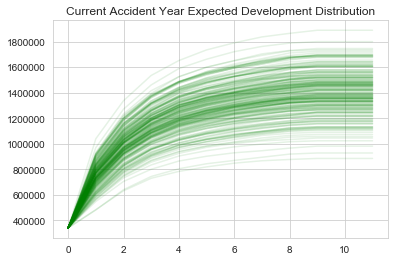

In [75]:
# Plot the data
current_year.iloc[:, :200].reset_index(drop=True).plot(
    color='green', legend=False, alpha=0.1,
    title='Current Accident Year Expected Development Distribution', grid=True);

### Recap
- The Mack method approaches stochastic reserving from a regression point of view<br>
- Bootstrap methods approach stochastic reserving from a simulation point of view<br>
- Where they assumptions of each model are not violated, they produce resonably consistent estimates of reserve variability<br>
- Mack does impose more assumptions (i.e. constraints) on the reserve estimate making the Bootstrap approach more suitable in a broader set of applciations<br>
- Both methods converge to their corresponding deterministic point estimates<br>